<a href="https://colab.research.google.com/github/Siji-Jaimal/Siji-Jaimal/blob/main/IMDb_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Save progress to a file
import pickle
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import LSTM

# Define timesteps and features
timesteps = 10  # Replace with the actual number of timesteps in your input data
features = 20   # Replace with the actual number of features in your input data

# Initialize a model (replace with your actual model)
model = Sequential()
model.add(LSTM(units=64, input_shape=(timesteps, features)))  # Now using the defined variables
# ... (some training code)

# Assume 'model' now holds the trained model
your_progress = {"model": model}
pickle.dump(your_progress, open('progress.pkl', 'wb'))

# Restart the runtime
from IPython.display import clear_output
clear_output()

# Load saved progress
your_progress = pickle.load(open('progress.pkl', 'rb'))
loaded_model = your_progress["model"]

# Continue your work, using 'loaded_model'
# ...

In [ ]:
!pip install kaggle

In [ ]:
import os
import json

from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

In [ ]:
kaggle_dictionary = json.load(open("kaggle.json"))

In [ ]:
kaggle_dictionary.keys()

dict_keys(['username', 'key'])

In [ ]:
os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

**IMDb DataSet Load**

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 drive		     imdb-dataset-of-50k-movie-reviews.zip   progress.pkl
'IMDB Dataset.csv'   kaggle.json			     sample_data


In [ ]:
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
  zip_ref.extractall()

In [ ]:
!ls

 drive		     imdb-dataset-of-50k-movie-reviews.zip   progress.pkl
'IMDB Dataset.csv'   kaggle.json			     sample_data


In [ ]:
data = pd.read_csv("/content/IMDB Dataset.csv")

data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


error message indicating that author  have exceeded the runtime type limitation while using a T4 GPU in Google Colab.

In [ ]:
data.shape

(50000, 2)

In [ ]:
data["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0
49999,No one expects the Star Trek movies to be high...,0


In [ ]:
data["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

**Data Cleaning**

**Function to strip HTML tags**

In [ ]:
def clean_html(text):
    # Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()



**Text Preprocessing Function**

In [ ]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())

In [ ]:
data['review_cleaned'] = data['review'].apply(lambda x : preprocessing_text(x))

In [ ]:
data.head()

,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei s love in the time of money is a...


In [ ]:
data.tail()

,review,sentiment,review_cleaned
49995,I thought this movie did a down right good job...,1,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,0,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,0,i m going to have to disagree with the previou...
49999,No one expects the Star Trek movies to be high...,0,no one expects the star trek movies to be high...


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import re

# Sample IMDb data
data = {
    'review': [
        'Great movie! Highly recommend it. <br> [Spoiler: The ending is amazing]',
        'Bad movie. Would not watch again. <br> [Critics: Terrible acting]',
        'Great movie! <br> Really enjoyed it. [Note: This is a must-watch]',
        'Bad movie. <br> Terrible acting! [Warning: Not suitable for kids]',
        'Great movie! Highly recommend it. <br> [Spoiler: The plot twist is great]'
    ]
}

imdb_data = pd.DataFrame(data)

# Function to strip HTML tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Function to denoise text
def denoise_text(text):
    text = strip_html(text)  # Remove HTML tags
    text = remove_between_square_brackets(text)  # Remove text within square brackets
    return text

# Apply the denoise function on the review column
imdb_data['review'] = imdb_data['review'].apply(denoise_text)

# Display the cleaned DataFrame
print("Cleaned IMDb Data:")
print(imdb_data)


Cleaned IMDb Data:
                                review
0  Great movie! Highly recommend it.  
1  Bad movie. Would not watch again.  
2    Great movie!  Really enjoyed it. 
3        Bad movie.  Terrible acting! 
4  Great movie! Highly recommend it.  


In [ ]:
print(train_data.shape)
print(test_data.shape)

(40000, 2)
(10000, 2)


**Data Preprocessing**

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [ ]:
print(X_train)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [ ]:
print(X_test)

[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [ ]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [ ]:
print(Y_train)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64


In [ ]:
print(X_train)


print("*****Test Data****")


print(X_test)

In [ ]:
print(X_train)

print("\033[1m********Test Data**********\033[0m")

print(X_test)


[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]
********Test Data**********
[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


**Long Short term Memory -LSTM**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**LSTM Compile**

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

**Training Model**

In [ ]:
model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 245s 485ms/step - accuracy: 0.7196 - loss: 0.5387 - val_accuracy: 0.8285 - val_loss: 0.3921
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 479ms/step - accuracy: 0.8476 - loss: 0.3634 - val_accuracy: 0.8428 - val_loss: 0.3715
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.8550 - loss: 0.3397 - val_accuracy: 0.8561 - val_loss: 0.3413
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 260s 477ms/step - accuracy: 0.8838 - loss: 0.2925 - val_accuracy: 0.8605 - val_loss: 0.3480
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 239s 478ms/step - accuracy: 0.8953 - loss: 0.2656 - val_accuracy: 0.8735 - val_loss: 0.3319


**Model Evaluation**

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.8755 - loss: 0.3102
Test Loss: 0.31002411246299744
Test Accuracy: 0.8784999847412109


**Perform Matrices**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int))
y_true = Y_test

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")



313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step
Accuracy: 0.88


In [ ]:
# Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")



Precision: 0.88
Recall: 0.88
F1-Score: 0.88


Epoch 1/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 202s 395ms/step - accuracy: 0.9197 - loss: 0.2049 - val_accuracy: 0.9163 - val_loss: 0.2170
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 262s 396ms/step - accuracy: 0.9276 - loss: 0.1894 - val_accuracy: 0.9216 - val_loss: 0.1986
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 251s 375ms/step - accuracy: 0.9528 - loss: 0.1312 - val_accuracy: 0.8972 - val_loss: 0.2776
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 205s 381ms/step - accuracy: 0.9645 - loss: 0.1025 - val_accuracy: 0.9116 - val_loss: 0.2612
Epoch 5/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 198s 373ms/step - accuracy: 0.9778 - loss: 0.0704 - val_accuracy: 0.9021 - val_loss: 0.2847


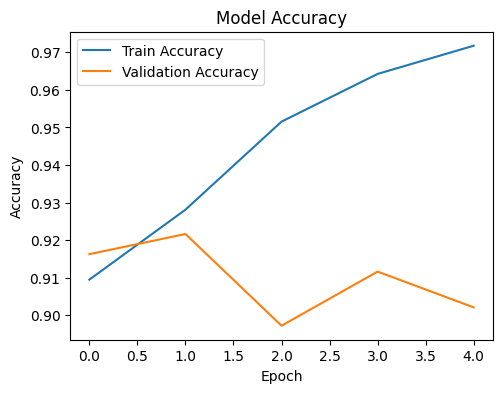

In [ ]:
 # Replace 10 with the desired number of epochs
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

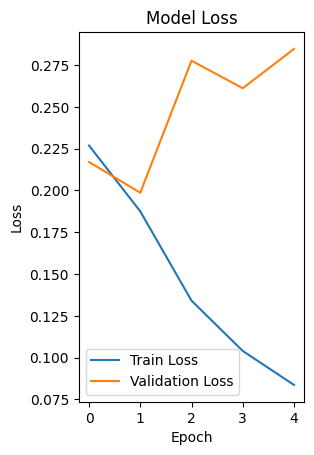

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.show()

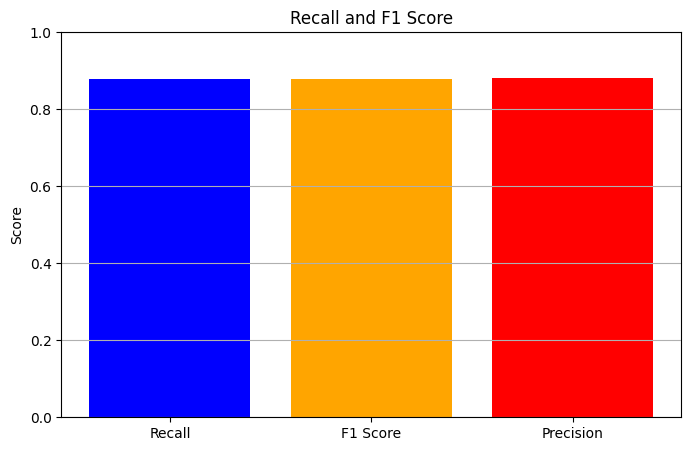

In [ ]:
metrics = ['Recall', 'F1 Score','Precision']
values = [recall, f1,precision]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange','red'])
plt.ylim(0, 1)
plt.title('Recall and F1 Score')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()

**Confusion Matrix**

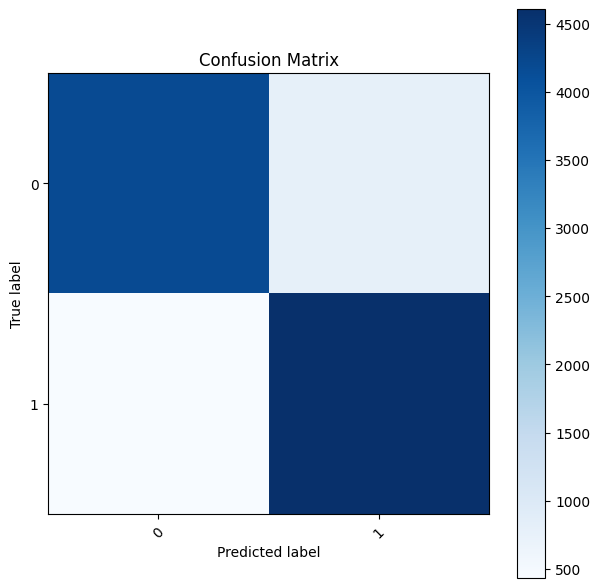

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(y_true)))
plt.xticks(tick_marks, rotation=45)
plt.yticks(tick_marks)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



**Binary Classification Model**

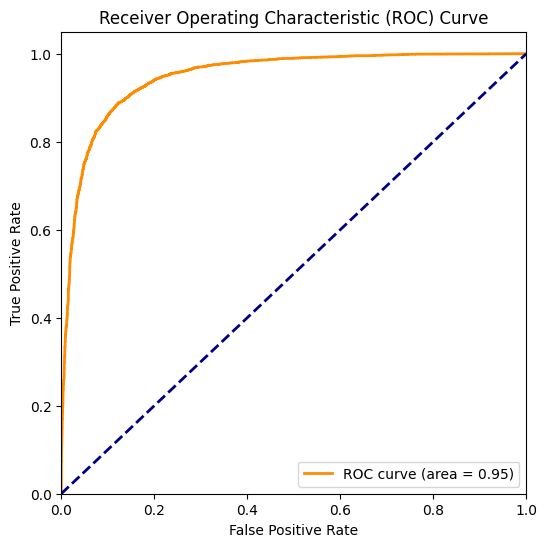

AUC-ROC Score: 0.95


In [ ]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred_probs.ravel())  # Flatten arrays for roc_curve
roc_auc = roc_auc_score(y_true, y_pred_probs)  # Use probabilities for AUC

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC Score: {roc_auc:.2f}")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

reviews = data['review'].values
sentiments = np.where(data['sentiment'] == 'positive', 1, 0)  # Encode sentiments

#if 'genre' in data.columns:
    #genres = data['genre'].values
#else:
    #print("Warning: 'genre' column not found in DataFrame. Skipping genre analysis.")
    #genres = None


# Extract prevalent themes
def extract_themes(reviews, sentiments):
    positive_reviews = reviews[sentiments == 1]
    negative_reviews = reviews[sentiments == 0]

    # Extract keywords from positive reviews
    positive_words = [word for review in positive_reviews for word in review.split()]
    positive_themes = Counter(positive_words).most_common(10)

    # Extract keywords from negative reviews
    negative_words = [word for review in negative_reviews for word in review.split()]
    negative_themes = Counter(negative_words).most_common(10)

    # Analyze themes by genre


    return positive_themes, negative_themes

# Call the function to extract themes
positive_themes, negative_themes = extract_themes(data['review'].values, sentiments)

# Print the results
print("Prevalent Themes in Positive Reviews:")
print(positive_themes)

print("\nPrevalent Themes in Negative Reviews:")
print(negative_themes)



Prevalent Themes in Positive Reviews:
[]

Prevalent Themes in Negative Reviews:
[('the', 568735), ('a', 306960), ('and', 301919), ('of', 283625), ('to', 261850), ('is', 203056), ('in', 169981), ('I', 132498), ('that', 126818), ('this', 113726)]


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
Most Common Positive Words:
[('the', 340558), ('?', 184206), ('and', 176578), ('a', 164221), ('of', 152096), ('to', 131300), ('is', 111812), ('in', 99191), ('br', 97954), ('it', 78115), ('i', 73109), ('this', 69619), ('that', 66817), ('as', 51092), ('with', 45708), ('for', 44225), ('was', 43328), ('film', 40997), ('but', 40699), ('movie', 37451)]

Most Common Negative Words:
[('the', 326199), ('?', 168862), ('a', 158579), ('and', 147759), ('of', 137283), ('to', 136779), ('br', 103997), ('is', 99229), ('in', 87499), ('i', 81778), ('this', 81322), ('it', 78686), ('that', 70169), ('was', 52257), ('movie', 49599), ('for', 43225), ('but', 42796), ('with', 41642), ('as', 40638), ('film', 36681)]


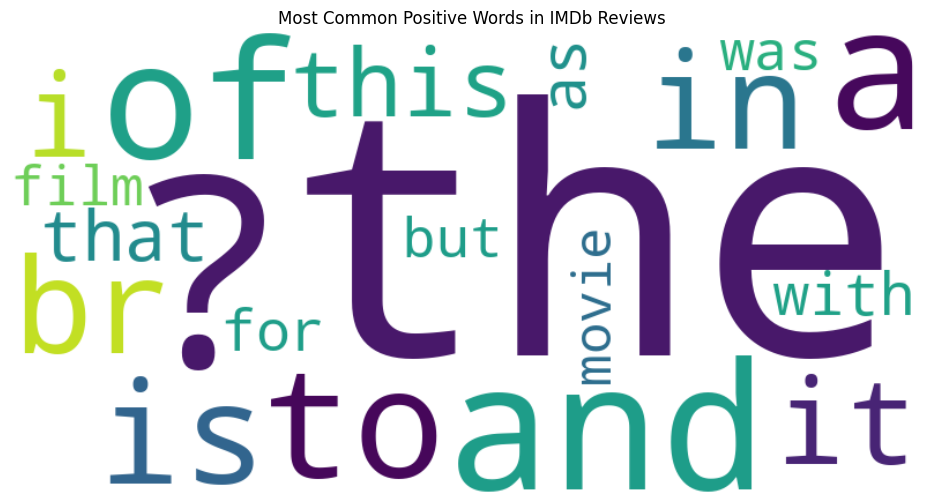

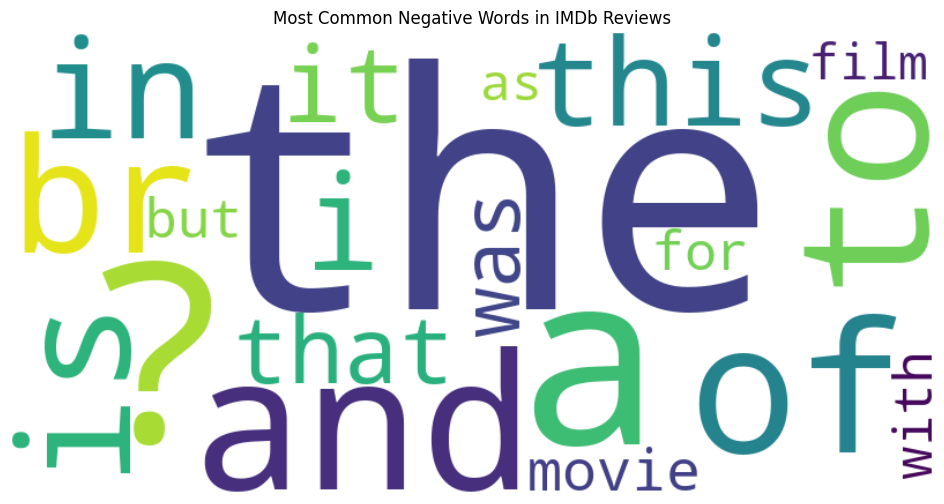

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from tensorflow import keras

max_features = 20000

# Load the IMDB dataset and obtain the word index
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
word_index = keras.datasets.imdb.get_word_index()  # Get word index from the IMDB dataset

# Create a reverse mapping from integer to word
reverse_word_index = {value: key for key, value in word_index.items()}
reverse_word_index[0] = '<PAD>'  # Padding token
# Function to decode reviews
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Decode the training and test reviews
decoded_train_reviews = [decode_review(review) for review in X_train]
decoded_test_reviews = [decode_review(review) for review in X_test]

# Combine the reviews and sentiments for analysis
all_reviews = decoded_train_reviews + decoded_test_reviews
all_labels = np.concatenate((y_train, y_test))

# Function to extract common words for each sentiment
def extract_common_words(reviews, labels):
    positive_words = []
    negative_words = []

    for review, label in zip(reviews, labels):
        words = review.split()
        if label == 1:  # Positive sentiment
            positive_words.extend(words)
        else:  # Negative sentiment
            negative_words.extend(words)

    return positive_words, negative_words

# Extract common words
positive_words, negative_words = extract_common_words(all_reviews, all_labels)

# Count the most common words
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Get the 20 most common words for each sentiment
most_common_positive = positive_word_counts.most_common(20)
most_common_negative = negative_word_counts.most_common(20)

# Print the most common words
print("Most Common Positive Words:")
print(most_common_positive)

print("\nMost Common Negative Words:")
print(most_common_negative)

# Visualize the most common positive words using WordCloud
plt.figure(figsize=(12, 6))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate_from_frequencies(dict(most_common_positive))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Positive Words in IMDb Reviews')
plt.show()

# Visualize the most common negative words using WordCloud
plt.figure(figsize=(12, 6))
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate_from_frequencies(dict(most_common_negative))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Negative Words in IMDb Reviews')
plt.show()

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Lingustic Features**

Most Common POS Tags in Positive Reviews:
[('NN', 1115870), ('JJ', 482445), ('NNS', 253623), ('RB', 251307), ('.', 184206), ('VB', 170602), ('VBZ', 125158), ('VBN', 110888), ('VBG', 100553), ('VBP', 88162)]

Most Common POS Tags in Negative Reviews:
[('NN', 1067173), ('JJ', 455922), ('RB', 268372), ('NNS', 237373), ('VB', 189643), ('.', 168862), ('VBZ', 116467), ('VBN', 110853), ('VBG', 109244), ('VBP', 91325)]


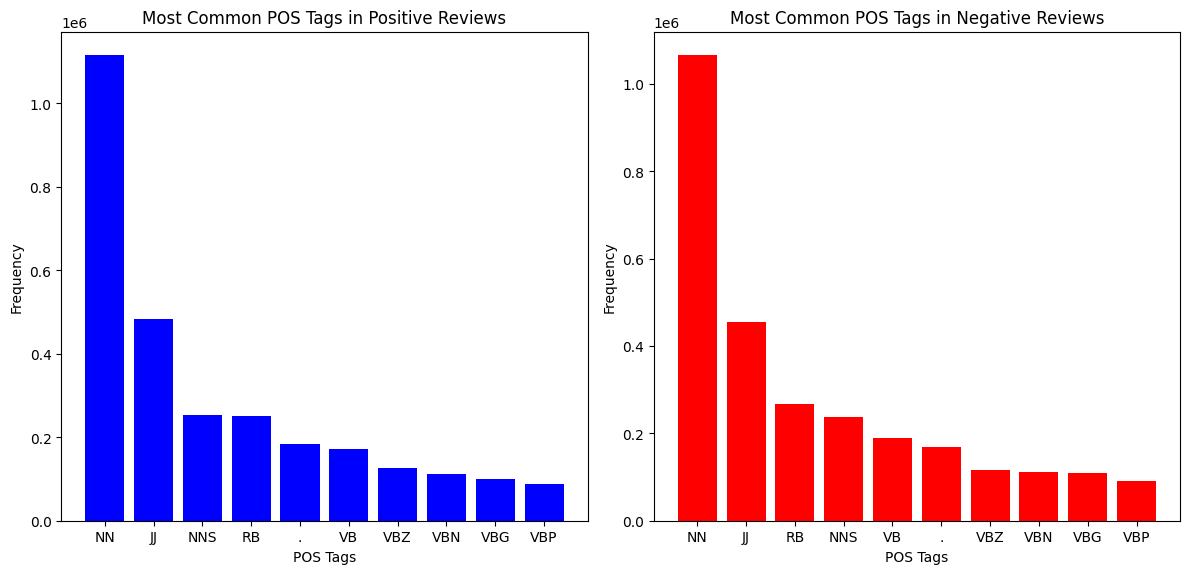

In [ ]:
def extract_linguistic_features(reviews, labels):
    positive_features = []
    negative_features = []

    for review, label in zip(reviews, labels):
        words = word_tokenize(review)
        pos_tags = pos_tag(words)

        # Filter out stopwords and keep POS tags
        filtered_tags = [(word, tag) for word, tag in pos_tags if word.lower() not in stopwords.words('english')]

        if label == 1:  # Positive sentiment
            positive_features.extend(filtered_tags)
        else:  # Negative sentiment
            negative_features.extend(filtered_tags)

    return positive_features, negative_features

# Extract linguistic features
positive_features, negative_features = extract_linguistic_features(all_reviews, all_labels)

# Count the most common POS tags for positive and negative sentiments
positive_pos_counts = Counter(tag for word, tag in positive_features)
negative_pos_counts = Counter(tag for word, tag in negative_features)

# Get the 10 most common POS tags for each sentiment
most_common_positive = positive_pos_counts.most_common(10)
most_common_negative = negative_pos_counts.most_common(10)

# Print the most common POS tags
print("Most Common POS Tags in Positive Reviews:")
print(most_common_positive)

print("\nMost Common POS Tags in Negative Reviews:")
print(most_common_negative)

# Visualize the most common POS tags using bar plots
labels_pos, counts_pos = zip(*most_common_positive)
labels_neg, counts_neg = zip(*most_common_negative)

plt.figure(figsize=(12, 6))

# Positive POS tags
plt.subplot(1, 2, 1)
plt.bar(labels_pos, counts_pos, color='blue')
plt.title('Most Common POS Tags in Positive Reviews')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')

# Negative POS tags
plt.subplot(1, 2, 2)
plt.bar(labels_neg, counts_neg, color='red')
plt.title('Most Common POS Tags in Negative Reviews')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
review_lengths = [len(review) for review in X_train]

# Find the maximum review length
max_review_length = max(review_lengths)

print(f'Maximum Review Length: {max_review_length}')



Maximum Review Length: 2494


In [ ]:
# Determine the desired maximum length for padding (e.g., based on analysis of review lengths)
maxlen = 500  # Replace 500 with the desired value

X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

# Print the shapes of the padded data
print("Padded Training Data Shape:", X_train.shape)
print("Padded Test Data Shape:", X_test.shape)

Padded Training Data Shape: (25000, 500)
Padded Test Data Shape: (25000, 500)


**Predictive Model**

In [ ]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [ ]:
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
The sentiment of the review is: positive


In [ ]:
new_review = "This movie was not that good"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

new_review = "This movie was ok but not that good."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The sentiment of the review is: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The sentiment of the review is: negative


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.5182 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7055 - loss: 0.6745 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.8671 - loss: 0.6398 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.9341 - loss: 0.5146 - val_accuracy: 0.5000 - val_loss: 0.7360
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 1.0000 - loss: 0.3069 - val_accuracy: 0.4000 - val_loss: 0.6913


<Axes: >

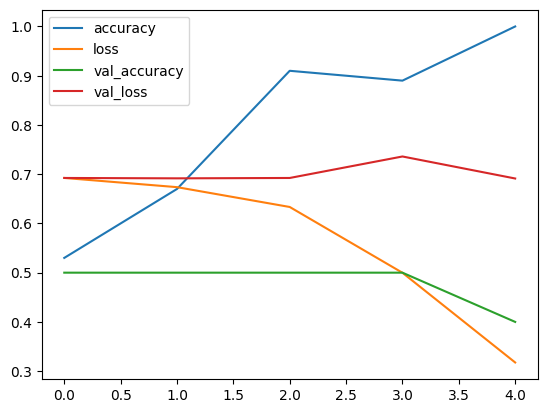

In [ ]:
# Import necessary libraries (assuming you're using TensorFlow/Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np # Import numpy for array manipulation

# Define your model architecture
model = Sequential()
model.add(Embedding(10000, 128))  # Example embedding layer
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load or create your training data here
# Example with placeholder data
X_train = np.random.randint(10000, size=(100, 100)) # Replace with your actual data
y_train = np.random.randint(2, size=(100, 1)) # Replace with your actual labels
X_val = np.random.randint(10000, size=(20, 100)) # Replace with your actual validation data
y_val = np.random.randint(2, size=(20, 1)) # Replace with your actual validation labels

# Now you can fit the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

pd.DataFrame(history.history).plot()

**Modified LSTM**

In [ ]:
!pip install tensorflow
import tensorflow.keras as keras

embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 952ms/step - accuracy: 0.5148 - loss: 0.6928 - val_accuracy: 0.6500 - val_loss: 0.6921
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step - accuracy: 0.5229 - loss: 0.6919 - val_accuracy: 0.6500 - val_loss: 0.6921
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.6046 - loss: 0.6920 - val_accuracy: 0.6500 - val_loss: 0.6920
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.6142 - loss: 0.6909 - val_accuracy: 0.6500 - val_loss: 0.6920
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.5979 - loss: 0.6912 - val_accuracy: 0.5500 - val_loss: 0.6920


<Axes: >

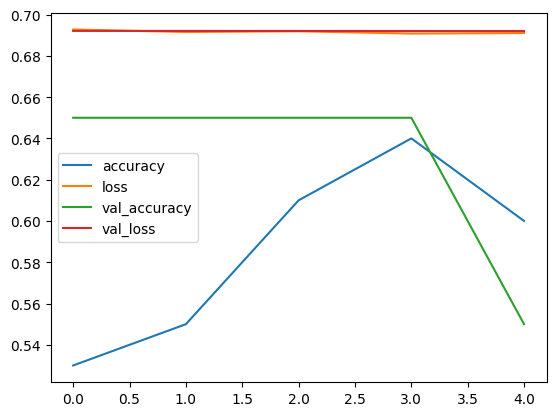

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping_cb]) # Changed y_valid to y_val

pd.DataFrame(history.history).plot()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


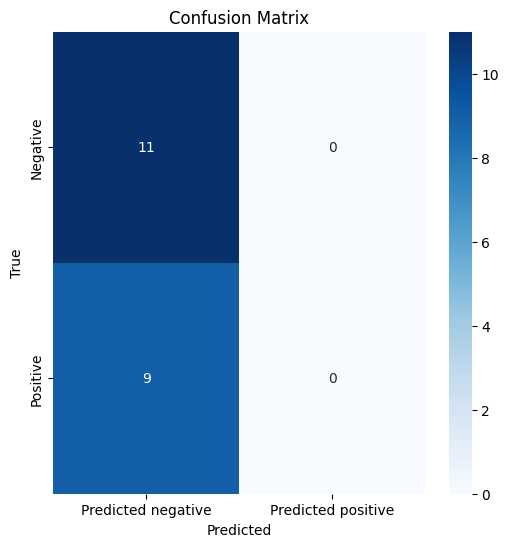

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install seaborn
import seaborn as sns # Import the Seaborn library

import sklearn.metrics as metrics # Import the metrics module

X_test = np.random.randint(10000, size=(20, 100)) # Replace with your actual test data
y_test = np.random.randint(2, size=(20, 1)) # Replace with your actual test labels

y_pred_probs = model_v2.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix and store it in 'cm'
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
# Use Seaborn's 'Blues' colormap
sns.heatmap(cm,
            annot=True, fmt='.0f', cmap='Blues',
            xticklabels=['Predicted negative', 'Predicted positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




print(metrics.classification_report(y_test, y_pred)) # Use metrics.classification_report

**Word Embedding**

782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step
              precision    recall  f1-score   support

           0       0.50      0.75      0.60     12500
           1       0.49      0.24      0.33     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.46     25000
weighted avg       0.50      0.50      0.46     25000



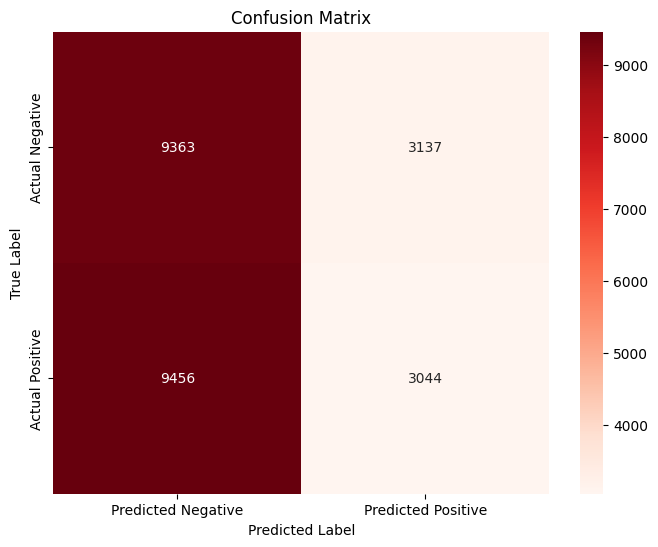

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.metrics import classification_report, confusion_matrix

# Load the IMDb dataset with the correct num_words to match the vocabulary size used during training
max_features = 10000  # Adjust this to the actual vocabulary size used during training
maxlen = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

# ... rest of your model definition and training code ...

# Make predictions (use the correct model variable name)
y_pred_prob = model_v2.predict(X_test)  # Assuming 'model_v2' is your trained model
y_pred = (y_pred_prob > 0.5).astype("int32")

# ... rest of your evaluation code ...

# Print classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.0f',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            cmap='Reds')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

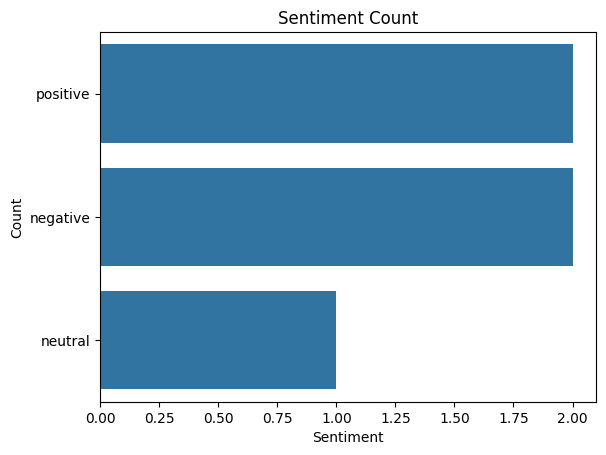

In [ ]:
import seaborn as sns
import pandas as pd # Import pandas to work with DataFrames

# Create a sample DataFrame (replace this with your actual data)
data = {'sentiment': ['positive', 'negative', 'positive', 'neutral', 'negative']}
df = pd.DataFrame(data)

sns.countplot(df["sentiment"])
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
from keras.datasets import imdb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load the IMDb dataset
max_features = 20000  # Number of words to consider as features
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Decode reviews back to text
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
reverse_word_index[0] = '<PAD>'  # Padding token

# Function to decode reviews
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Prepare the training data for TF-IDF
train_reviews = [decode_review(review) for review in X_train]
test_reviews = [decode_review(review) for review in X_test]

# Combine train and test reviews for TF-IDF calculation
all_reviews = train_reviews + test_reviews

# Calculate TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_reviews)

# Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF values for the first few reviews
print("TF-IDF Values for the first few reviews:")
print(tfidf_df.head())

# Optionally, you can split the TF-IDF matrix back into train and test sets
X_train_tfidf = tfidf_matrix[:len(train_reviews)]
X_test_tfidf = tfidf_matrix[len(train_reviews):]

# Proceed with train-test split if needed
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)

# Now you can use X_train_tfidf and y_train for training your model

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
TF-IDF Values for the first few reviews:
    00  000  007   01   02   05   06   10  100  1000  ...  zone  zoo  zoom  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   0.0   

   zooms  zorro   zp   zu  zucker  zulu  zuniga  
0    0.0    0.0  0.0  0.0     0.0   0.0     0.0  
1    0.0    0.0  0.0  0.0     0.0   0.0     0.0  
2    0.0    0.0  0.0  0.0     0.0   0.0     0.0  
3    0.0    0.0  0.0  0.0     0.0   0.0     0.0  
4    0.0    0.0  0.0  0.0     0.0   0.0     0.0  

[5 rows x 19196 columns]
